# L2 Regularization

### Imports

In [1]:
from __future__ import print_function
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os


from art.utils import load_cifar10
from art.attacks import CarliniL2Method, CarliniLInfMethod
from art.classifiers import PyTorchClassifier


%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [2]:
# Read CIFAR10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single = DataLoader(test_dataset, batch_size=1)

### Inputs

In [33]:
path = Path("C:/Users/Matach/Documents/Imperial College London/FYP/saved_models/CIFAR10/L2")
file = "l2_regularized_1e-05_model_2.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

## Model

In [34]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dr

## Carlini

In [35]:
# Generate adversarial test examples
def CarliniL2(classifier, x_test, init_const):
    start = time.time()
    attack = CarliniL2Method(classifier=classifier,
                            confidence=0.0,
                            targeted=False,
                            learning_rate=0.01,
                            binary_search_steps=2,
                            initial_const=init_const,
                            batch_size=64)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
    
    return x_test_adv

def CarliniLInf(classifier, x_test, epsilon):
    start = time.time()
    attack = CarliniLInfMethod(classifier=classifier, 
                              confidence=0.0,
                              targeted=False, 
                              learning_rate=0.01,
                              eps=epsilon, 
                              batch_size=128)
    x_test_adv = attack.generate(x=x_test)
    end = time.time()
    
    return x_test_adv

# Calculate distance 
def L2distance(x_test, x_test_adv):
    dist = 0
    samples_changed = 0
    for test, adv_test in zip(x_test, x_test_adv):
        l2 = np.linalg.norm(test-adv_test)
        dist += l2
        samples_changed = samples_changed + 1 if l2>0 else samples_changed
    dist /= samples_changed
    return dist

### L2

In [36]:
constants = [0.001, 0.01, 0.025, 0.05, 0.1]
n = 1000
accuracies = []
distances = []
for init in constants:
    x_test_adv = CarliniL2(classifier, x_test[:n], init_const=init)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))
    dist = L2distance(x_test[:n], x_test_adv)
    distances.append(round(dist, 3))

    print('c:', init, ' Accuracy:', acc, ' Distance:', round(distances[-1], 3))

c: 0.001  Accuracy: 0.778  Distance: 0.018
c: 0.01  Accuracy: 0.439  Distance: 0.105
c: 0.025  Accuracy: 0.224  Distance: 0.169
c: 0.05  Accuracy: 0.148  Distance: 0.208
c: 0.1  Accuracy: 0.128  Distance: 0.231


In [37]:
print(accuracies, distances)

[0.778, 0.439, 0.224, 0.148, 0.128] [0.018, 0.105, 0.169, 0.208, 0.231]


In [38]:
a = np.mean([
    [0.747, 0.323, 0.179, 0.141, 0.133] ,
    [0.778, 0.439, 0.224, 0.148, 0.128]
], axis=0)
a

array([0.7625, 0.381 , 0.2015, 0.1445, 0.1305])

In [39]:
b = np.mean([
[0.025, 0.128, 0.18, 0.208, 0.237],
    [0.018, 0.105, 0.169, 0.208, 0.231]
], axis=0)
b

array([0.0215, 0.1165, 0.1745, 0.208 , 0.234 ])

In [30]:
carlini_regularized_l2 ={
    '0': {'accuracies': [0.71, 0.28, 0.15, 0.12, 0.12],
  'distances': [0.028, 0.12, 0.16, 0.187, 0.22]},
 '1e-03': {'accuracies': [0.7885, 0.471, 0.239, 0.149, 0.1245],
  'distances': [0.017, 0.0985, 0.16, 0.195, 0.2175]},
 '1e-04': {'accuracies': [0.765, 0.3965, 0.2205, 0.143, 0.1205],
  'distances': [0.0205, 0.1085, 0.162, 0.1975, 0.2245]},
 '1e-05': {'accuracies': [0.7625, 0.381, 0.2015, 0.1445, 0.1305],
  'distances': [0.0215, 0.1165, 0.1745, 0.208, 0.234]}}


### LInf

In [45]:
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]


In [26]:
epsilons = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006]
n = 1000
accuracies = []
for eps in epsilons:
    x_test_adv = CarliniLInf(classifier, x_test[:n], epsilon=eps)
    predictions = classifier.predict(x_test_adv)
    acc = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:n], axis=1)) / n
    accuracies.append(round(acc, 3))

    print('eps:', eps, ' Accuracy:', acc)

print(accuracies)

eps: 0.001  Accuracy: 0.772
eps: 0.002  Accuracy: 0.697
eps: 0.003  Accuracy: 0.613
eps: 0.004  Accuracy: 0.557
eps: 0.005  Accuracy: 0.482
eps: 0.006  Accuracy: 0.407
[0.772, 0.697, 0.613, 0.557, 0.482, 0.407]


In [43]:
carlini_regularized_linf = {
        '0': [0.751, 0.654, 0.57 , 0.48 , 0.41, 0.353],
    '1e-03': [0.7835, 0.728 , 0.6475, 0.5625, 0.4895, 0.418 ],
    '1e-04': [0.7725, 0.7105, 0.6395, 0.5625, 0.492 , 0.421 ],
    '1e-05': [0.771 , 0.7135, 0.6365, 0.558 , 0.4945, 0.4405],
}

## Results

### L2

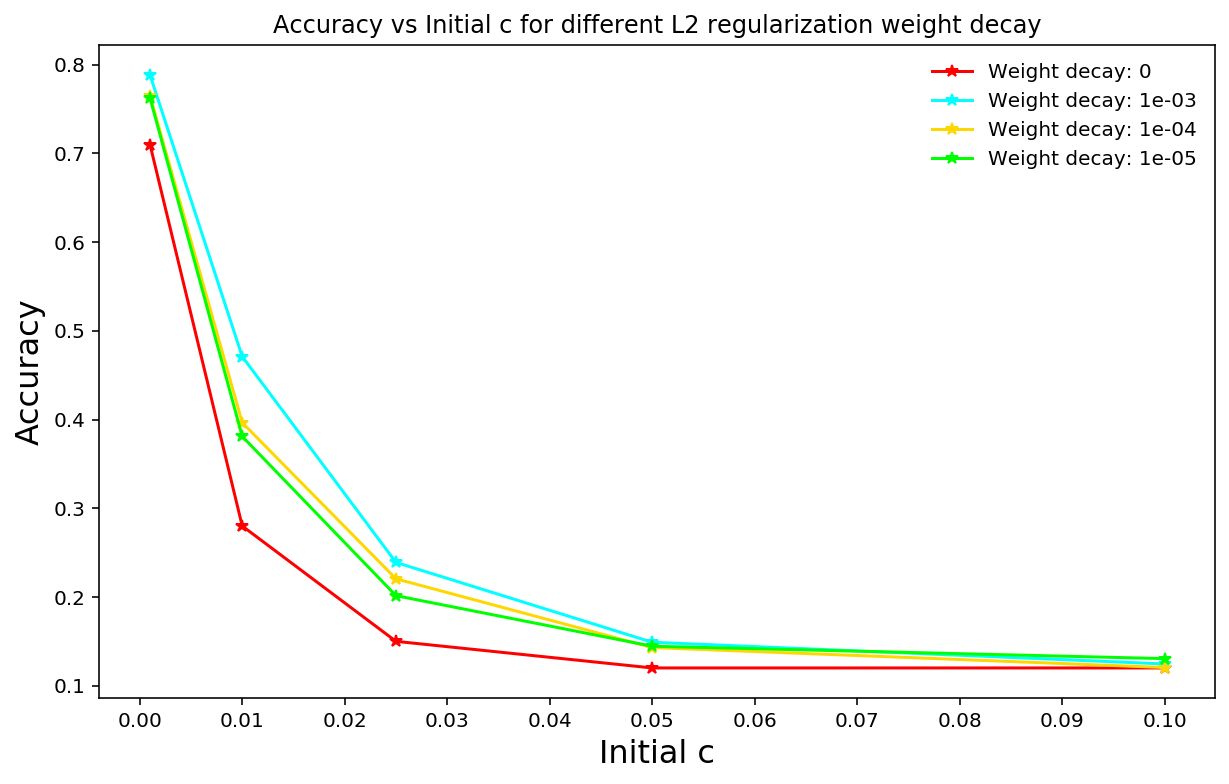

In [41]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime']

for idx, (decay, results) in enumerate(carlini_regularized_l2.items()):
    plt.plot(constants, results['accuracies'], "*-", color=colors[idx], label="Weight decay: {}".format(decay))

# plt.yticks(np.arange(0, 0.6, step=0.1))
plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("Accuracy vs Initial c for different L2 regularization weight decay")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

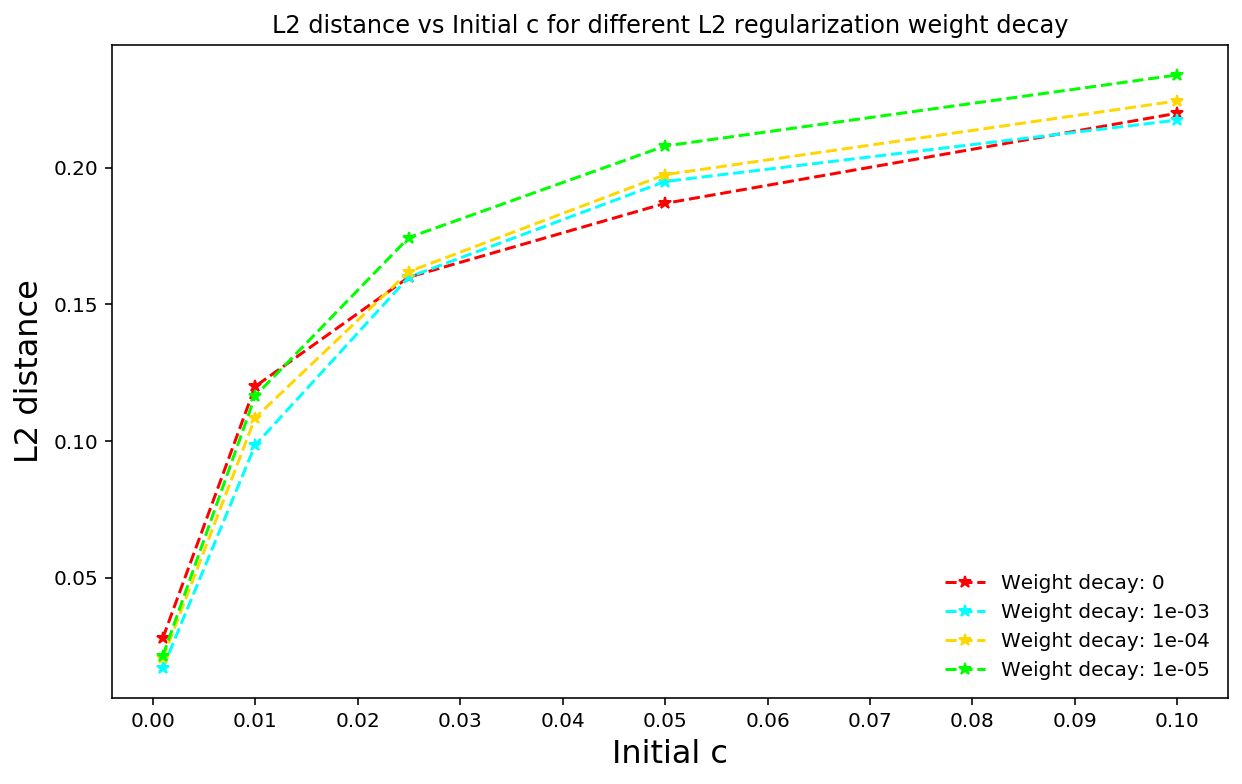

In [42]:
# plot the pruned accuracies vs constant c

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime']

for idx, (decay, results) in enumerate(carlini_regularized_l2.items()):
    plt.plot(constants, results['distances'], "*--", color=colors[idx], label="Weight decay: {}".format(decay))

plt.xticks(np.arange(0, 0.11, step=0.01))
plt.title("L2 distance vs Initial c for different L2 regularization weight decay")
plt.xlabel("Initial c",fontsize=16)
plt.ylabel("L2 distance",fontsize=16)
plt.legend(loc='lower right', frameon=False)
plt.show()

### LInf

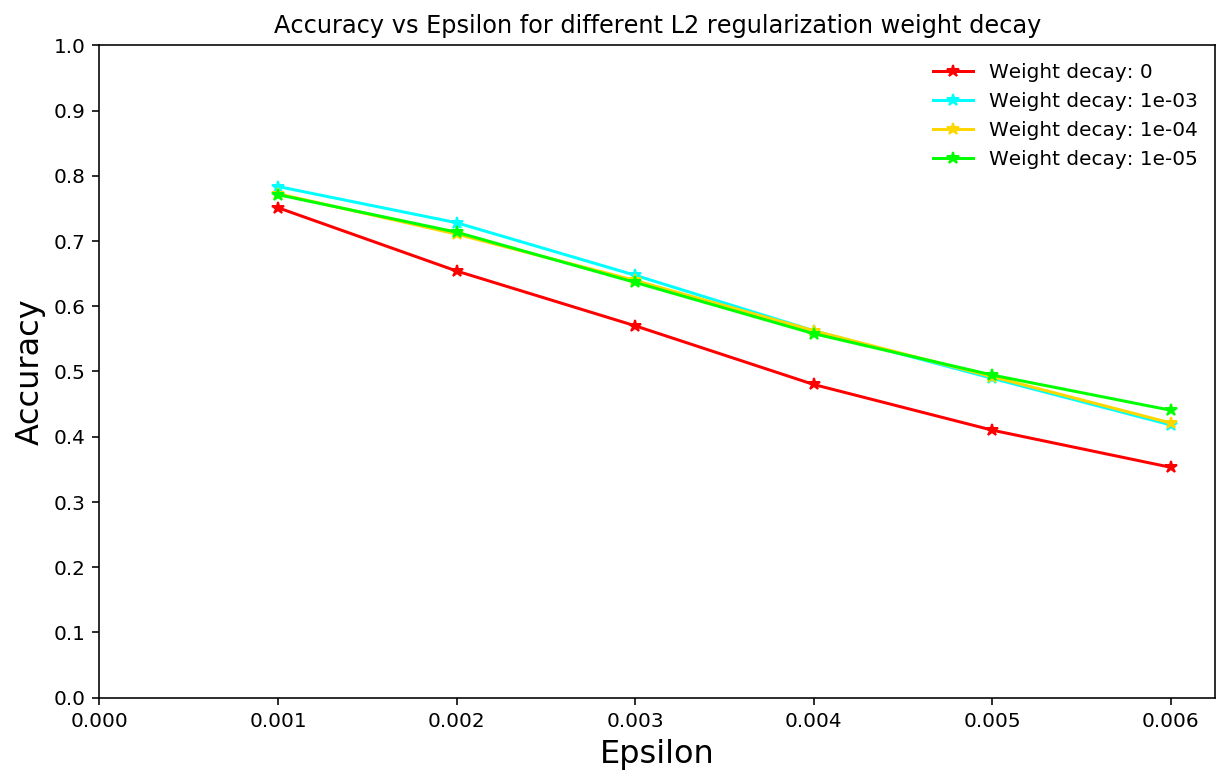

In [46]:
# plot the pruned accuracies vs epsilon

plt.figure(figsize=(10,6))
colors =  ['red', 'aqua', 'gold', 'lime']

for idx, (decay, results) in enumerate(carlini_regularized_linf.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label="Weight decay: {}".format(decay))

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.0061, step=0.001))
plt.title("Accuracy vs Epsilon for different L2 regularization weight decay")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='upper right', frameon=False)
plt.show()

In [47]:
carlini_regularized_l2

{'0': {'accuracies': [0.71, 0.28, 0.15, 0.12, 0.12],
  'distances': [0.028, 0.12, 0.16, 0.187, 0.22]},
 '1e-03': {'accuracies': [0.7885, 0.471, 0.239, 0.149, 0.1245],
  'distances': [0.017, 0.0985, 0.16, 0.195, 0.2175]},
 '1e-04': {'accuracies': [0.765, 0.3965, 0.2205, 0.143, 0.1205],
  'distances': [0.0205, 0.1085, 0.162, 0.1975, 0.2245]},
 '1e-05': {'accuracies': [0.7625, 0.381, 0.2015, 0.1445, 0.1305],
  'distances': [0.0215, 0.1165, 0.1745, 0.208, 0.234]}}

In [48]:
carlini_regularized_linf

{'0': [0.751, 0.654, 0.57, 0.48, 0.41, 0.353],
 '1e-03': [0.7835, 0.728, 0.6475, 0.5625, 0.4895, 0.418],
 '1e-04': [0.7725, 0.7105, 0.6395, 0.5625, 0.492, 0.421],
 '1e-05': [0.771, 0.7135, 0.6365, 0.558, 0.4945, 0.4405]}